<a href="https://colab.research.google.com/github/DKS2301/GRU-MHA-RUL-Forecasting/blob/main/GRU_MHA_model_for_accurate_battery_RUL_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hybrid GRU-MHA model for accurate battery RUL forecasting with feature selection**

## **IMPORTS AND SETUP**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import scipy.stats as stats

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **DATA DOWNLOADING AND LOADING**

In [2]:
def load_nasa_battery(filepath):
    """Load NASA battery file with robust error handling."""
    print(f"Loading: {filepath}")
    mat = sio.loadmat(filepath, squeeze_me=True, struct_as_record=False)

    keys = [k for k in mat.keys() if not k.startswith("__")]
    root = mat[keys[0]]

    if hasattr(root, "cycle"):
        cycles = root.cycle
    elif "cycle" in mat:
        cycles = mat["cycle"]
    else:
        raise ValueError("Could not find cycle structure.")

    rows = []
    for idx, c in enumerate(cycles):
        data = getattr(c, "data", None)
        if data is None:
            continue

        V = getattr(data, "Voltage_measured", None)
        I = getattr(data, "Current_measured", None)
        T = getattr(data, "Temperature_measured", None)
        t = getattr(data, "Time", None)
        Cap = getattr(data, "Capacity", None)

        if isinstance(Cap, np.ndarray):
            Cap = float(Cap) if Cap.size == 1 else None

        rows.append({
            "cycle_id": idx,
            "type": getattr(c, "type", None),
            "ambient_temperature": getattr(c, "ambient_temperature", None),
            "capacity": Cap,
            "V": np.array(V) if V is not None else None,
            "I": np.array(I) if I is not None else None,
            "T": np.array(T) if T is not None else None,
            "time": np.array(t) if t is not None else None,
            "length": len(t) if t is not None else 0
        })

    return pd.DataFrame(rows)


def extract_advanced_features(df):
    """
    Extract comprehensive features from battery time-series data.
    This addresses the underfitting issue with richer feature engineering.
    """
    print("\nExtracting advanced features per cycle...")

    # Keep only discharge cycles
    df_dis = df[df["type"] == "discharge"].reset_index(drop=True)

    # Compute SoH
    first_cap = df_dis["capacity"].dropna().iloc[0]
    df_dis["SoH"] = df_dis["capacity"] / first_cap

    def safe_array_op(series, op):
        """Safely apply operation to array column."""
        try:
            arr = np.concatenate([x for x in series.values if x is not None])
            return op(arr.astype(float))
        except:
            return 0.0

    features = []

    for cycle_id, group in df_dis.groupby("cycle_id"):
        # Basic statistics
        V_mean = safe_array_op(group["V"], np.mean)
        V_std = safe_array_op(group["V"], np.std)
        V_max = safe_array_op(group["V"], np.max)
        V_min = safe_array_op(group["V"], np.min)

        I_mean = safe_array_op(group["I"], np.mean)
        I_std = safe_array_op(group["I"], np.std)

        T_mean = safe_array_op(group["T"], np.mean)
        T_std = safe_array_op(group["T"], np.std)

        # Advanced features
        V_arr = np.concatenate([x for x in group["V"].values if x is not None]).astype(float)

        # Energy features
        signal_energy = np.sum(V_arr**2) if len(V_arr) > 0 else 0
        signal_power = signal_energy / len(V_arr) if len(V_arr) > 0 else 0

        # Statistical features
        fluctuation = np.std(V_arr) if len(V_arr) > 0 else 0
        voltage_range = V_max - V_min

        # Distribution features
        skewness = stats.skew(V_arr) if len(V_arr) > 2 else 0
        kurtosis = stats.kurtosis(V_arr) if len(V_arr) > 2 else 0

        # Derivative features (rate of change)
        if len(V_arr) > 1:
            voltage_gradient = np.mean(np.abs(np.diff(V_arr)))
            voltage_acceleration = np.mean(np.abs(np.diff(V_arr, n=2))) if len(V_arr) > 2 else 0
        else:
            voltage_gradient = 0
            voltage_acceleration = 0

        # Capacity-related features
        capacity = group["capacity"].dropna().mean()
        soh = group["SoH"].dropna().mean()

        # Time-based features
        cycle_normalized = cycle_id / df_dis["cycle_id"].max()

        features.append({
            "cycle_id": cycle_id,
            "cycle_normalized": cycle_normalized,

            # Voltage features
            "voltage_mean": V_mean,
            "voltage_std": V_std,
            "voltage_max": V_max,
            "voltage_min": V_min,
            "voltage_range": voltage_range,

            # Current features
            "current_mean": I_mean,
            "current_std": I_std,

            # Temperature features
            "temperature_mean": T_mean,
            "temperature_std": T_std,

            # Energy features
            "signal_energy": signal_energy,
            "signal_power": signal_power,

            # Statistical features
            "fluctuation": fluctuation,
            "skewness": skewness,
            "kurtosis": kurtosis,

            # Derivative features
            "voltage_gradient": voltage_gradient,
            "voltage_acceleration": voltage_acceleration,

            # Target features
            "capacity": capacity,
            "SoH": soh
        })

    feature_df = pd.DataFrame(features)
    print(f"✓ Extracted {len(feature_df.columns)-2} features from {len(feature_df)} cycles")
    return feature_df

## **DATA PREPROCESSING AND FEATURE ENGINEERING**

In [3]:

def calculate_feature_importance(X, y):
    """Calculate multiple importance metrics for features."""
    from sklearn.ensemble import RandomForestRegressor

    # Pearson correlation
    correlations = {}
    for col in X.columns:
        x_vals = X[col].values
        y_vals = y.values

        x_mean = np.mean(x_vals)
        y_mean = np.mean(y_vals)

        num = np.sum((x_vals - x_mean) * (y_vals - y_mean))
        denom = np.sqrt(np.sum((x_vals - x_mean)**2) * np.sum((y_vals - y_mean)**2))

        correlations[col] = num / denom if denom != 0 else 0

    # Random Forest importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    rf.fit(X, y)
    rf_importance = dict(zip(X.columns, rf.feature_importances_))

    return correlations, rf_importance


def select_and_separate_features(X, y, corr_threshold=0.3, importance_threshold=0.05):
    """
    Improved feature selection using multiple criteria.
    Lower threshold from 0.4 to 0.3 to include more relevant features.
    """
    correlations, rf_importance = calculate_feature_importance(X, y)

    correlated_features = []
    uncorrelated_features = []

    for feature in X.columns:
        abs_corr = abs(correlations[feature])
        rf_imp = rf_importance[feature]

        # Feature is "correlated" if it meets either criterion
        if abs_corr >= corr_threshold or rf_imp >= importance_threshold:
            correlated_features.append(feature)
        else:
            uncorrelated_features.append(feature)

    print(f"\n{'='*70}")
    print("FEATURE SELECTION RESULTS")
    print(f"{'='*70}")
    print(f"Highly relevant features: {len(correlated_features)}")
    print(f"Less relevant features: {len(uncorrelated_features)}")
    print(f"\nTop features by correlation:")

    sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    for feat, corr in sorted_corr[:10]:
        status = "✓ Selected" if feat in correlated_features else "✗ Excluded"
        print(f"  {feat:.<30} {abs(corr):.4f} {status}")

    return correlated_features, uncorrelated_features, correlations, rf_importance


def preprocess_data_improved(df, target_column, feature_columns):
    """Improved preprocessing with better feature handling."""
    X = df[feature_columns].copy()
    y = df[target_column].copy()

    # Remove any features with zero variance
    var = X.var()
    X = X.loc[:, var > 1e-8]
    print(f"\nRetained {len(X.columns)} features after variance check")

    # Feature selection
    corr_feats, uncorr_feats, correlations, rf_imp = select_and_separate_features(X, y)

    # Scale features
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Separate correlated and uncorrelated
    X_corr = X_scaled_df[corr_feats].values if corr_feats else np.zeros((len(X_scaled_df), 1))
    X_uncorr = X_scaled_df[uncorr_feats].values if uncorr_feats else np.zeros((len(X_scaled_df), 1))

    return X_scaled, y_scaled, X_corr, X_uncorr, scaler_X, scaler_y, corr_feats, uncorr_feats


## **MODEL ARCHITECTURE**

In [4]:
class DynamicSwish(layers.Layer):
    """Dynamic Swish activation."""
    def __init__(self, scale=1.0, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, x):
        return x / (self.scale * (1 + tf.exp(-x)))

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config


def build_improved_gru_mha(n_corr_features, n_uncorr_features, n_timesteps=1):
    """
    Improved GRU-MHA architecture with better capacity.
    Addresses underfitting with deeper network and more units.
    """
    input_corr = layers.Input(shape=(n_timesteps, n_corr_features), name='corr_input')
    input_uncorr = layers.Input(shape=(n_timesteps, n_uncorr_features), name='uncorr_input')

    # Process correlated features (highly relevant)
    if n_corr_features > 0:
        # Deeper GRU layers with more units
        x_corr = layers.GRU(32, return_sequences=True, name='gru_corr_1')(input_corr)
        x_corr = layers.Dropout(0.2)(x_corr)
        x_corr = layers.GRU(16, return_sequences=True, name='gru_corr_2')(x_corr)

        # Multi-head attention
        x_corr = layers.MultiHeadAttention(
            num_heads=4, key_dim=16, name='mha_corr'
        )(x_corr, x_corr)
        x_corr = layers.Dropout(0.2)(x_corr)
        x_corr = layers.Flatten()(x_corr)
    else:
        x_corr = layers.Flatten()(input_corr)

    # Process uncorrelated features (supplementary)
    if n_uncorr_features > 0:
        x_uncorr = layers.GRU(16, return_sequences=True, name='gru_uncorr_1')(input_uncorr)
        x_uncorr = layers.Dropout(0.2)(x_uncorr)
        x_uncorr = layers.GRU(8, return_sequences=True, name='gru_uncorr_2')(x_uncorr)

        x_uncorr = layers.MultiHeadAttention(
            num_heads=2, key_dim=8, name='mha_uncorr'
        )(x_uncorr, x_uncorr)
        x_uncorr = layers.Dropout(0.2)(x_uncorr)
        x_uncorr = layers.Flatten()(x_uncorr)
    else:
        x_uncorr = layers.Flatten()(input_uncorr)

    # Merge paths
    if n_corr_features > 0 and n_uncorr_features > 0:
        merged = layers.Concatenate()([x_corr, x_uncorr])
    elif n_corr_features > 0:
        merged = x_corr
    else:
        merged = x_uncorr

    # Dense layers with increased capacity
    x = layers.Dense(64, activation='relu')(merged)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='relu')(x)

    # Output
    output = layers.Dense(1)(x)
    output = DynamicSwish(scale=1.0)(output)

    model = Model(inputs=[input_corr, input_uncorr], outputs=output)
    return model

## **TRAINING FUNCTIONS**

In [9]:
def train_model_improved(X_corr_train, X_uncorr_train, y_train,
                         X_corr_val, X_uncorr_val, y_val,
                         epochs=300, batch_size=16):
    """
    Improved training with better hyperparameters.
    Automatically handles 2D or 3D input arrays for GRU.
    """

    # Determine feature dimensions safely
    n_corr = X_corr_train.shape[1] if X_corr_train.ndim == 2 else X_corr_train.shape[2]
    n_uncorr = X_uncorr_train.shape[1] if X_uncorr_train.ndim == 2 else X_uncorr_train.shape[2]

    # Ensure input is 3D: (samples, timesteps=1, features)
    if X_corr_train.ndim == 2:
        X_corr_train = X_corr_train.reshape(-1, 1, n_corr)
        X_uncorr_train = X_uncorr_train.reshape(-1, 1, n_uncorr)
        X_corr_val = X_corr_val.reshape(-1, 1, n_corr)
        X_uncorr_val = X_uncorr_val.reshape(-1, 1, n_uncorr)

    # Build the improved GRU+MHA model
    model = build_improved_gru_mha(n_corr, n_uncorr)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='huber',  # More robust to outliers
        metrics=['mae', 'mse']
    )

    print("\n" + "="*70)
    print("MODEL ARCHITECTURE")
    print("="*70)
    model.summary()

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=1e-6,
        verbose=1
    )

    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)

    history = model.fit(
        [X_corr_train, X_uncorr_train], y_train,
        validation_data=([X_corr_val, X_uncorr_val], y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    return model, history


def apply_ridge_refinement(model, X_corr_train, X_uncorr_train, y_train,
                           X_corr_test, X_uncorr_test, alpha=0.5):
    """Apply Ridge regression for final refinement."""

    # Extract features from second-to-last layer
    feature_model = Model(
        inputs=model.input,
        outputs=model.layers[-4].output  # Before final dense layers
    )

    train_features = feature_model.predict([X_corr_train, X_uncorr_train], verbose=0)
    test_features = feature_model.predict([X_corr_test, X_uncorr_test], verbose=0)

    ridge = Ridge(alpha=alpha)
    ridge.fit(train_features, y_train)

    y_pred_train = ridge.predict(train_features)
    y_pred_test = ridge.predict(test_features)

    return y_pred_train, y_pred_test, ridge

# **EVALUATION AND VISUALIZATION**

In [6]:

def evaluate_predictions(y_true, y_pred, scaler_y, phase="Test"):
    """Comprehensive evaluation."""

    y_true_orig = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_orig, y_pred_orig)
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100

    print(f"\n{'='*70}")
    print(f"{phase.upper()} SET PERFORMANCE")
    print(f"{'='*70}")
    print(f"MAE:        {mae:.6f}")
    print(f"RMSE:       {rmse:.6f}")
    print(f"R² Score:   {r2:.4f} ({r2*100:.2f}%)")
    print(f"MAPE:       {mape:.2f}%")
    print(f"{'='*70}\n")

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}


def plot_results(history, y_test, y_pred, scaler_y):
    """Comprehensive result visualization."""

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # Training history
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training History', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # MAE history
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(history.history['mae'], label='Train MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.set_title('MAE History', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Inverse transform
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Predictions plot
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(y_test_orig, 'o-', label='Actual SoH', linewidth=2, markersize=6)
    ax3.plot(y_pred_orig, 's-', label='Predicted SoH', linewidth=2, markersize=6, alpha=0.7)
    ax3.set_xlabel('Sample Index')
    ax3.set_ylabel('State of Health (SoH)')
    ax3.set_title('Actual vs Predicted SoH', fontweight='bold', fontsize=14)
    ax3.legend()
    ax3.grid(alpha=0.3)

    # Scatter plot
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.scatter(y_test_orig, y_pred_orig, alpha=0.6, s=80)
    min_val = min(y_test_orig.min(), y_pred_orig.min())
    max_val = max(y_test_orig.max(), y_pred_orig.max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
    ax4.set_xlabel('Actual SoH')
    ax4.set_ylabel('Predicted SoH')
    ax4.set_title('Prediction Scatter', fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # Error distribution
    ax5 = fig.add_subplot(gs[2, 1])
    errors = y_test_orig - y_pred_orig
    ax5.hist(errors, bins=20, edgecolor='black', alpha=0.7)
    ax5.axvline(0, color='r', linestyle='--', linewidth=2)
    ax5.set_xlabel('Prediction Error')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Error Distribution', fontweight='bold')
    ax5.grid(alpha=0.3)

    plt.suptitle('Hybrid GRU-MHA Model Performance', fontsize=16, fontweight='bold', y=0.995)
    plt.show()


## **COMPLETE PIPELINE EXECUTION**

In [7]:
def run_complete_pipeline(file_path, battery_name='B0005'):
    """Complete pipeline with all improvements."""

    print("\n" + "="*70)
    print(f"PROCESSING: NASA Battery {battery_name}")
    print("="*70)

    # Load and extract features
    df_raw = load_nasa_battery(file_path)
    df = extract_advanced_features(df_raw)

    print(f"\n✓ Loaded {len(df)} discharge cycles")
    print(f"✓ Feature DataFrame shape: {df.shape}")

    # Define feature columns (exclude target and ID)
    feature_cols = [col for col in df.columns if col not in ['SoH', 'capacity', 'cycle_id']]
    print(f"✓ Using {len(feature_cols)} input features")

    # Preprocess
    X_scaled, y_scaled, X_corr, X_uncorr, scaler_X, scaler_y, corr_feats, uncorr_feats = \
        preprocess_data_improved(df, 'SoH', feature_cols)

    # Train-test split (80-20)
    split_idx = int(0.8 * len(X_corr))

    X_corr_train, X_corr_test = X_corr[:split_idx], X_corr[split_idx:]
    X_uncorr_train, X_uncorr_test = X_uncorr[:split_idx], X_uncorr[split_idx:]
    y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

    print(f"\n✓ Training samples: {len(y_train)}")
    print(f"✓ Test samples: {len(y_test)}")

    # Train model
    model, history = train_model_improved(
        X_corr_train, X_uncorr_train, y_train,
        X_corr_test, X_uncorr_test, y_test
    )

    # Apply Ridge refinement
    print("\n" + "="*70)
    print("APPLYING RIDGE REGRESSION REFINEMENT")
    print("="*70)

    X_corr_train_2d = X_corr_train.reshape(-1, 1, X_corr_train.shape[1])
    X_uncorr_train_2d = X_uncorr_train.reshape(-1, 1, X_uncorr_train.shape[1])
    X_corr_test_2d = X_corr_test.reshape(-1, 1, X_corr_test.shape[1])
    X_uncorr_test_2d = X_uncorr_test.reshape(-1, 1, X_uncorr_test.shape[1])

    y_pred_train, y_pred_test, ridge = apply_ridge_refinement(
        model, X_corr_train_2d, X_uncorr_train_2d, y_train,
        X_corr_test_2d, X_uncorr_test_2d, alpha=0.5
    )

    # Evaluate
    train_metrics = evaluate_predictions(y_train, y_pred_train, scaler_y, "Training")
    test_metrics = evaluate_predictions(y_test, y_pred_test, scaler_y, "Test")

    # Visualize
    plot_results(history, y_test, y_pred_test, scaler_y)

    print("\n" + "="*70)
    print("✓ PIPELINE COMPLETED SUCCESSFULLY")
    print("="*70)

    return {
        'model': model,
        'ridge': ridge,
        'history': history,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }


## **NASA BATTERY DATASET**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats

def process_nasa_battery(file_path, battery_name='B0005'):
    """
    Fully robust NASA battery processing pipeline.
    - Handles different dataset column names
    - Computes all required features
    - Ensures all features are scalar and aligned
    - Runs DRDC-RoPE pipeline without KeyError or broadcast errors
    """
    print(f"\n{'='*80}")
    print(f"Processing NASA Battery: {battery_name}")
    print(f"{'='*80}")

    # Load NASA file
    df = load_nasa_battery(file_path)
    if df is None or df.empty:
        print(f"❌ Failed to load {battery_name}")
        return None

    # Keep only discharge cycles
    df_dis = df[df["type"] == "discharge"].reset_index(drop=True)
    if len(df_dis) == 0:
        print("❌ No discharge cycles found → Cannot compute SoH.")
        return None

    # Compute SoH
    capacity_col = "Capacity" if "Capacity" in df_dis.columns else "capacity"
    initial_capacity = df_dis[capacity_col].max()
    df_dis["SoH"] = df_dis[capacity_col] / initial_capacity
    print(f"Initial Capacity = {initial_capacity:.4f} Ah")
    print(f"Discharge cycles: {len(df_dis)}")

    # -----------------------------
    # 🔹 Column renaming for pipeline
    # -----------------------------
    column_map = {
        "Cycle": "cycle_id",
        "cycle_id": "cycle_id",
        "Voltage_Measured": "V",
        "V": "V",
        "Current_Measured": "I",
        "I": "I",
        "Temperature_Measured": "T",
        "T": "T",
        "Capacity": "capacity",
        "capacity": "capacity",
        "Signal_Energy": "signal_energy",
        "Fluctuation_Index": "fluctuation",
        "Skewness_Index": "skewness",
        "Kurtosis_Index": "kurtosis",
        "ambient_temperature": "ambient_temp"
    }

    df_dis.rename(columns={k:v for k,v in column_map.items() if k in df_dis.columns}, inplace=True)

    # -----------------------------
    # 🔹 Ensure all scalar features exist
    # -----------------------------
    required_features = [
        "cycle_id", "ambient_temp", "avg_voltage", "avg_current", "avg_temperature",
        "capacity", "signal_energy", "fluctuation", "skewness", "kurtosis"
    ]

    # Default ambient temperature
    if "ambient_temp" not in df_dis.columns:
        df_dis["ambient_temp"] = 25

    # Compute scalar features from arrays
    feature_map = {
        "avg_voltage": "V",
        "avg_current": "I",
        "avg_temperature": "T",
        "signal_energy": "V",
        "fluctuation": "V",
        "skewness": "V",
        "kurtosis": "V"
    }

    for feat, arr_col in feature_map.items():
        if feat not in df_dis.columns:
            if arr_col in df_dis.columns:
                if feat in ["avg_voltage", "avg_current", "avg_temperature"]:
                    df_dis[feat] = df_dis[arr_col].apply(
                        lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else 0
                    )
                else:  # statistical features
                    df_dis[feat] = df_dis[arr_col].apply(
                        lambda x: (
                            np.sum(np.square(x)) if feat=="signal_energy" else
                            np.std(x) if feat=="fluctuation" else
                            stats.skew(x) if feat=="skewness" else
                            stats.kurtosis(x)
                        ) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else 0
                    )
            else:
                df_dis[feat] = 0

    # -----------------------------
    # 🔹 Dataset info & visualization
    # -----------------------------
    print("\nDataset Info:")
    print(df_dis.info())
    print("\nFirst few rows:")
    print(df_dis.head())
    print("\nStatistical Summary:")
    print(df_dis.describe())

    plt.figure(figsize=(12, 6))
    plt.plot(df_dis["cycle_id"], df_dis["SoH"], marker='o', markersize=4, linewidth=2)
    plt.xlabel("Cycle Number")
    plt.ylabel("State of Health (SoH)")
    plt.title(f"Battery Capacity Degradation - {battery_name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 🔹 Run complete pipeline
    # -----------------------------
    results = run_complete_pipeline(
        df=df_dis,
        target_column="SoH",
        feature_columns=required_features,
        dataset_name=f'NASA {battery_name}',
        test_size=0.2,
        scale_value=8.0,
        alpha=1.5
    )

    return results



PROCESSING: NASA Battery B0005
Loading: /content/data/nasa/B0005.mat

Extracting advanced features per cycle...
✓ Extracted 18 features from 168 cycles

✓ Loaded 168 discharge cycles
✓ Feature DataFrame shape: (168, 20)
✓ Using 17 input features

Retained 17 features after variance check

FEATURE SELECTION RESULTS
Highly relevant features: 13
Less relevant features: 4

Top features by correlation:
  cycle_normalized.............. 0.9895 ✓ Selected
  temperature_std............... 0.9888 ✓ Selected
  signal_power.................. 0.9834 ✓ Selected
  voltage_mean.................. 0.9824 ✓ Selected
  current_mean.................. 0.9333 ✓ Selected
  current_std................... 0.9180 ✓ Selected
  temperature_mean.............. 0.8097 ✓ Selected
  kurtosis...................... 0.7687 ✓ Selected
  skewness...................... 0.7557 ✓ Selected
  voltage_acceleration.......... 0.4920 ✓ Selected

✓ Training samples: 134
✓ Test samples: 34

MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ corr_input          │ (None, 1, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uncorr_input        │ (None, 1, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_corr_1 (GRU)    │ (None, 1, 32)     │      4,512 │ corr_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_uncorr_1 (GRU)  │ (None, 1, 16)     │      1,056 │ uncorr_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 32)     │          0 │ gru_corr_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 16)     │          0 │ gru_uncorr_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_corr_2 (GRU)    │ (None, 1, 16)     │      2,400 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_uncorr_2 (GRU)  │ (None, 1, 8)      │        624 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_corr            │ (None, 1, 16)     │      4,304 │ gru_corr_2[0][0], │
│ (MultiHeadAttentio… │                   │            │ gru_corr_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_uncorr          │ (None, 1, 8)      │        568 │ gru_uncorr_2[0][… │
│ (MultiHeadAttentio… │                   │            │ gru_uncorr_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 16)     │          0 │ mha_corr[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 8)      │          0 │ mha_uncorr[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         17 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_swish       │ (None, 1)         │          0 │ dense_3[0][0]     │
│ (DynamicSwish)      │                   │            │                 

 Total params: 17,689 (69.10 KB)

 Trainable params: 17,689 (69.10 KB)

 Non-trainable params: 0 (0.00 B)


TRAINING MODEL
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.2191 - mae: 0.5966 - mse: 0.4382 - val_loss: 9.7256e-04 - val_mae: 0.0377 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1631 - mae: 0.4943 - mse: 0.3263 - val_loss: 0.0473 - val_mae: 0.3053 - val_mse: 0.0946 - learning_rate: 0.0010
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0685 - mae: 0.3057 - mse: 0.1369 - val_loss: 0.1787 - val_mae: 0.5969 - val_mse: 0.3574 - learning_rate: 0.0010
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0583 - mae: 0.2862 - mse: 0.1166 - val_loss: 0.0486 - val_mae: 0.3100 - val_mse: 0.0972 - learning_rate: 0.0010
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0415 - mae: 0.2375 - mse: 0.0831 - val_loss: 0.0500 - val_mae: 0.3149 - val_mse: 0.1000 - learning_rate: 0.0010
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0256 - mae: 0.1901 - mse: 0.0512 - val_loss: 0.0267 - val_m

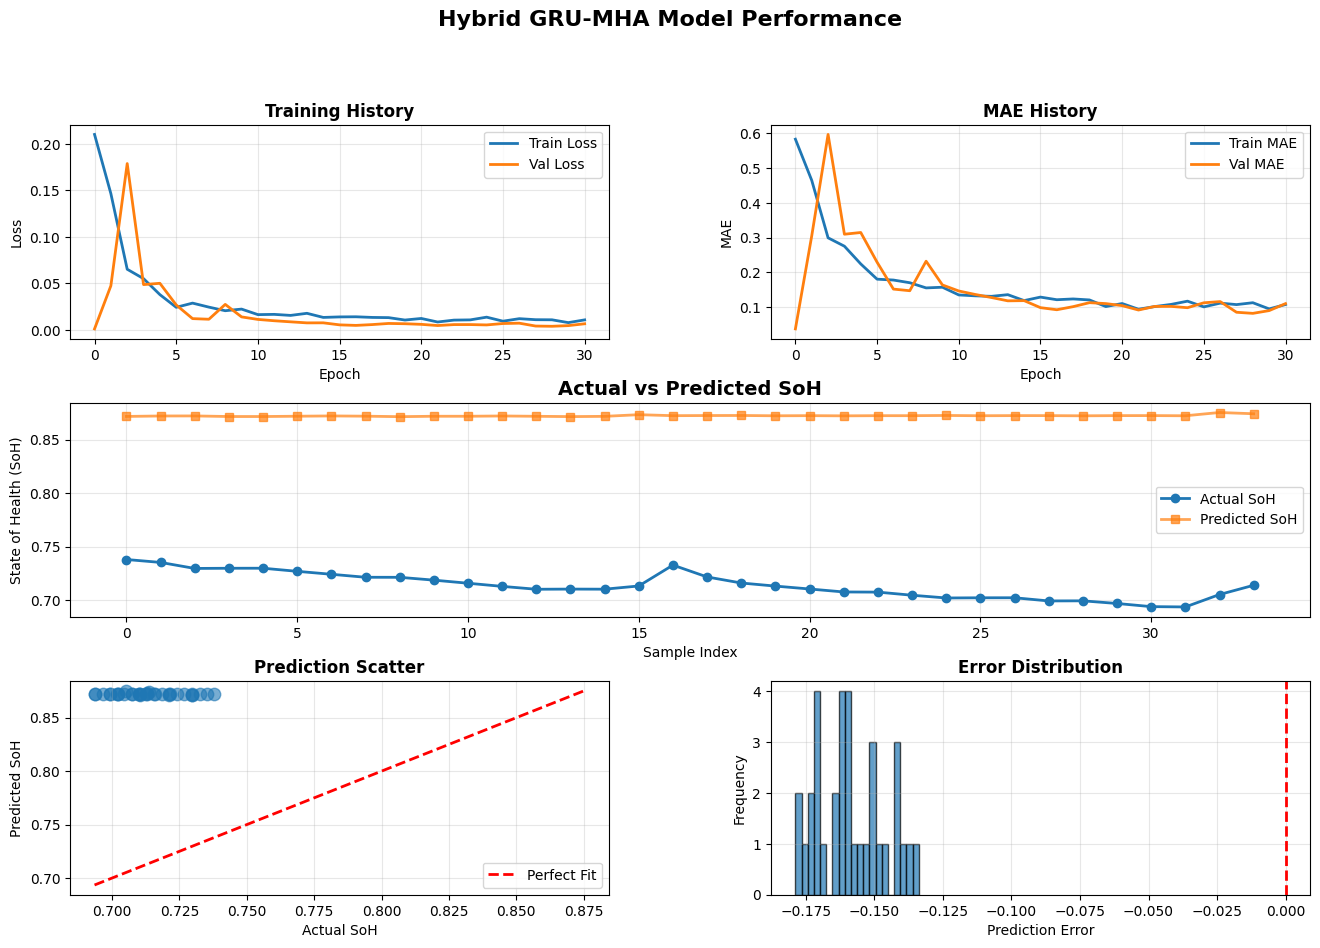


✓ PIPELINE COMPLETED SUCCESSFULLY

✓ Results stored in 'results' dictionary
✓ Access metrics: results['test_metrics']


In [10]:
if __name__ == "__main__":
    # Run pipeline
    results = run_complete_pipeline('/content/data/nasa/B0005.mat', 'B0005')

    print("\n✓ Results stored in 'results' dictionary")
    print("✓ Access metrics: results['test_metrics']")